# RUL Prediction using 1D-CNN

# Introduction

In this notebook, we demonstrate the process of predicting the Remaining Useful Life (RUL) of battery cells using a 1D Convolutional Neural Network (CNN) approach. Our workflow includes:

1. **Data Loading and Preprocessing**  
   - Load the battery degradation dataset and define a specific end-of-life (EOL) threshold.  
   - Compute the RUL for each cell based on its capacity drop to the chosen threshold and filter out invalid or insufficiently long sequences.  
   - Bin the RUL values into discrete categories for classification.

2. **Exploratory Data Analysis (EDA)**  
   - Visualize sample capacity trajectories (history + target) to see how different cells degrade.  
   - Plot histograms of continuous and binned RUL values to understand their distribution.

3. **Data Preparation for Modeling**  
   - Ensure reproducibility by setting random seeds.  
   - Split the data by cell into training, validation, and test sets (no cell overlap to avoid data leakage).  
   - Create fixed-length historical capacity sequences (last 120 points) and scale them with `MinMaxScaler`.  
   - Convert the binned RUL labels into one-hot encodings for multi-class classification.

4. **Model Building and Hyperparameter Tuning**  
   - Define a 1D CNN architecture with multiple convolutional and pooling layers to classify the binned RUL.  
   - Use Keras Tuner (`kerastuner`) to perform a random search over hyperparameters (e.g., filter sizes, kernel sizes, L2 regularization, learning rate).  
   - Train multiple models, monitor validation performance, and select the best model configuration.

5. **Model Evaluation**  
   - Retrain the best model on the combined training and validation data, then evaluate on the held-out test set.  
   - Inspect accuracy, confusion matrices, and classification reports to quantify performance.  
   - Illustrate model interpretability by applying Grad-CAM to visualize which parts of the input sequences influenced the CNN’s predictions.

Through this end-to-end pipeline—covering data loading, RUL computation, classification, model training, and interpretability—you will gain insights into predicting battery health and understanding your model’s decision-making process.


In [21]:
# Standard libraries
import random

# Third-party libraries
import mat4py as mpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



# Keras Tuner
import kerastuner as kt


In [2]:
# Ensure reproducibility
np.random.seed(None)
random.seed(None)
tf.random.set_seed(None)

## Data Loading and Preprocessing

### Data loading

In [3]:
# Load the dataset
file_path = "../../data/Degradation_Prediction_Dataset_ISEA.mat"  
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

### Preprocessing

#### Feature Engineering - Remaining Useful Life (RUL)

In [4]:


# -------------------------------------
# Define the percentage for end-of-life
# -------------------------------------
eol_percentage = 0.65  # e.g., 0.65 for EOL65, or 0.80 for EOL80

# --------------------------------------------------------
# Function to compute EOL and RUL given a specified fraction
# --------------------------------------------------------
def compute_eol_and_rul(row, fraction):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol_cycle, rul = np.nan, np.nan
    
    # Handle edge cases: missing data
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL": eol_cycle, "RUL": rul})
    
    # The threshold is fraction * initial_capacity
    initial_capacity = history_cap[0]
    threshold = fraction * initial_capacity

    # If the last historical capacity is already below threshold, we can't compute a future RUL
    if history_cap[-1] <= threshold:
        return pd.Series({"EOL": np.nan, "RUL": np.nan})
    
    # Handle target data edge cases
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL": eol_cycle, "RUL": rul})

    # Find the first index in target where capacity drops below threshold
    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol_index = below_threshold_indices[0]
        eol_cycle = target_cycles[eol_index]

    # Compute RUL = EOL cycle - last history cycle
    if not pd.isna(eol_cycle):
        last_history_cycle = history_cycles[-1]
        rul = eol_cycle - last_history_cycle

    return pd.Series({"EOL": eol_cycle, "RUL": rul})

# -------------------------------------------------------
# Apply the function to your DataFrame (df) and filter
# -------------------------------------------------------
df[["EOL", "RUL"]] = df.apply(lambda row: compute_eol_and_rul(row, eol_percentage), axis=1)

# Drop rows where RUL is NaN (invalid entries)
df_filtered = df.dropna(subset=["RUL"])

# (Optional) Filter out any rows whose history has fewer than 120 time steps
df_filtered = df_filtered[df_filtered["History"].apply(lambda x: len(x) >= 120)]


#### Binning RUL for Classification

The RUL values are binned into discrete categories for classification. This is done to be able to use GRAD-CAM for interpretability, which requires a classification model. 

In [5]:
# Define bins and labels
bins = [0, 200, 300, 400, 500, 600, 700, np.inf]
labels = ["0-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700+"]

# Apply binning to the RUL column
df_filtered["RUL_binned"] = pd.cut(df_filtered["RUL"], bins=bins, labels=labels, include_lowest=True)

# Inspect bin distribution
print("Binned RUL Distribution:\n", df_filtered["RUL_binned"].value_counts())


Binned RUL Distribution:
 RUL_binned
200-300    940
300-400    940
400-500    940
500-600    936
600-700    830
700+       792
0-200      655
Name: count, dtype: int64


#### Visualize RUL and Binned RUL

/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_33258/1129491212.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



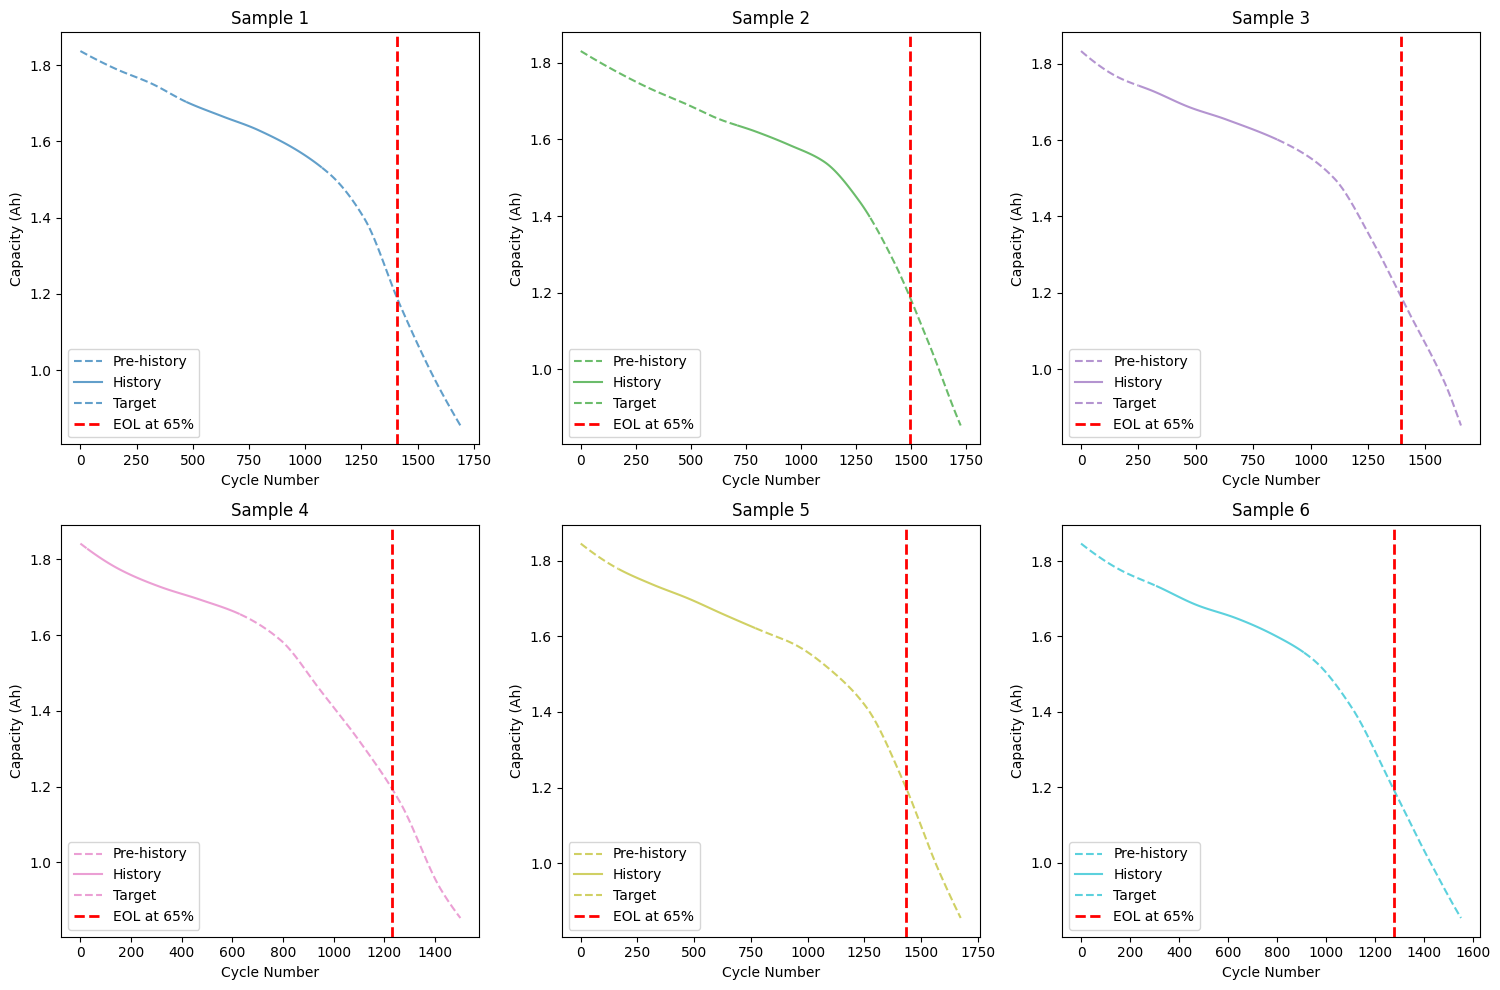

In [76]:
# ---------------------------------------------
# Select random unique samples for visualization
# ---------------------------------------------

num_samples_to_plot = min(6, len(df_filtered))  # Ensure we plot at most 6 samples
sampled_indices = random.sample(range(len(df_filtered)), num_samples_to_plot)  # Select random indices
df_sampled = df_filtered.iloc[sampled_indices]  # Extract corresponding rows from the dataset

# ---------------------------------------------
# Create subplots for visualizing sample trajectories
# ---------------------------------------------

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Assign distinct colors to each sample
cmap = cm.get_cmap("tab10", num_samples_to_plot)

# ---------------------------------------------
# Loop through sampled data and plot each sample
# ---------------------------------------------

for i, (_, row) in enumerate(df_sampled.iterrows()):
    ax = axes[i]  # Select subplot for the current sample

    # Extract relevant arrays from the row
    history_cycles = np.array(row["History_Cycle"])  # Cycle numbers for history
    history_cap = np.array(row["History"])  # Capacity values for history
    target_cycles = np.array(row["Target_Cycle_Expanded"])  # Cycle numbers for future target
    target_cap = np.array(row["Target_expanded"])  # Capacity values for future target
    eol_cycle = row["EOL"]  # End-of-life cycle number

    # Assign a unique color for this sample
    color = cmap(i)

    # ---------------------------------------------
    # Identify the last 120 historical time steps
    # ---------------------------------------------
    n_history = len(history_cycles)  # Total number of history time steps
    split_idx = max(0, n_history - 120)  # Index where the last 120 cycles start

    # Split data into "Pre-history" (earlier cycles) and "History" (last 120 cycles)
    pre_history_cycles = history_cycles[:split_idx]  # Older historical cycles
    pre_history_cap = history_cap[:split_idx]  # Older capacity values

    last_history_cycles = history_cycles[split_idx:]  # Last 120 cycles (or full history if <120)
    last_history_cap = history_cap[split_idx:]  # Corresponding capacity values

    # ---------------------------------------------
    # Plot different phases of the sample trajectory
    # ---------------------------------------------

    # Plot "Pre-history" in dashed lines (only if history has more than 120 cycles)
    if split_idx > 0:
        ax.plot(pre_history_cycles, pre_history_cap, 
                color=color, alpha=0.7, linestyle="dashed", label="Pre-history")

    # Plot last 120 steps of history in solid lines
    ax.plot(last_history_cycles, last_history_cap, 
            color=color, alpha=0.7, linestyle="solid", label="History")

    # Plot future target trajectory (dashed line)
    ax.plot(target_cycles, target_cap, 
            color=color, alpha=0.7, linestyle="dashed", label="Target")

    # Mark End-of-Life (EOL) cycle if available
    if not np.isnan(eol_cycle):
        ax.axvline(eol_cycle, color="red", linestyle="--", linewidth=2, 
                   label=f"EOL at {int(eol_percentage*100)}%")

    # ---------------------------------------------
    # Formatting the subplot
    # ---------------------------------------------
    ax.set_title(f"Sample {i+1}")  # Title of the subplot
    ax.set_xlabel("Cycle Number")  # X-axis label
    ax.set_ylabel("Capacity (Ah)")  # Y-axis label
    ax.legend()  # Show legend

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()


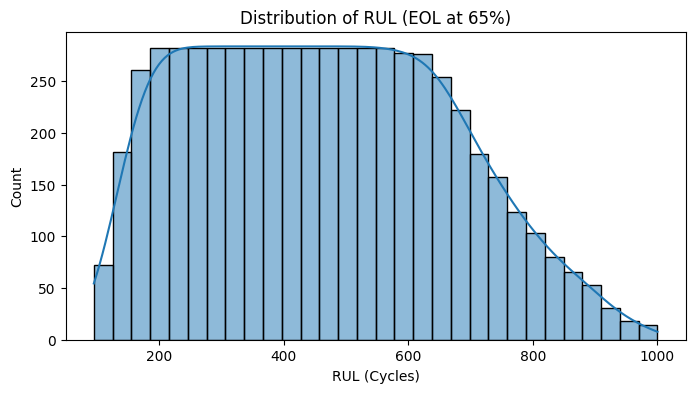

In [77]:
# ---------------------------------------------
# Plot the distribution of Remaining Useful Life (RUL)
# ---------------------------------------------

plt.figure(figsize=(8, 4))  # Set figure size for better readability

# Create a histogram with Kernel Density Estimate (KDE) to visualize RUL distribution
sns.histplot(df_filtered["RUL"], bins=30, kde=True)  

# Label the axes
plt.xlabel("RUL (Cycles)")  # X-axis: Remaining Useful Life in cycles
plt.ylabel("Count")  # Y-axis: Number of occurrences

# Add a descriptive title, dynamically showing the EOL percentage used
plt.title(f"Distribution of RUL (EOL at {int(eol_percentage*100)}%)")

# Display the plot
plt.show()


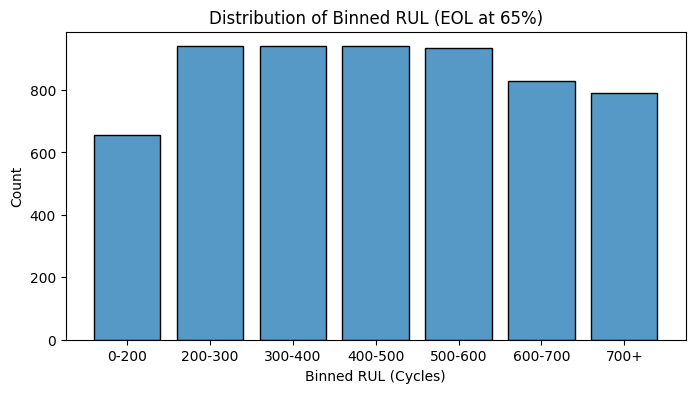

In [78]:
# ---------------------------------------------
# Plot the distribution of Binned Remaining Useful Life (RUL)
# ---------------------------------------------

plt.figure(figsize=(8, 4))  # Set figure size for better visualization

# Create a histogram for binned RUL categories
sns.histplot(df_filtered["RUL_binned"], discrete=True, shrink=0.8)  

# Label the axes
plt.xlabel("Binned RUL (Cycles)")  # X-axis: Binned RUL categories
plt.ylabel("Count")  # Y-axis: Number of samples in each bin

# Add a title, dynamically including the EOL percentage
plt.title(f"Distribution of Binned RUL (EOL at {int(eol_percentage*100)}%)")

# Display the plot
plt.show()


### Continued data preprocessing

#### Class label encoding

In [ ]:
# ----------------------------------------------------------------
# 4a) Define class labels and map them to integers
# ----------------------------------------------------------------
label_mapping = {label: i for i, label in enumerate(labels)}

# This assumes df_filtered["RUL_binned"] is already created
df_filtered["RUL_binned_int"] = df_filtered["RUL_binned"].map(label_mapping)

# ----------------------------------------------------------------
# 5) Split by Cell into train/val/test
# ----------------------------------------------------------------
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)

train_ratio = 0.8
split_index = int(len(unique_cells) * train_ratio)
train_cells = unique_cells[:split_index]
test_cells  = unique_cells[split_index:]

df_train_test = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test       = df_filtered[df_filtered["Cell"].isin(test_cells)]

# Further split train_test => train & val
val_ratio = 0.2
val_index = int(len(train_cells) * (1 - val_ratio))
val_cells = train_cells[val_index:]
train_cells = train_cells[:val_index]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_val   = df_filtered[df_filtered["Cell"].isin(val_cells)]

# ----------------------------------------------------------------
# 6) Prepare Data for Each Split
#    - remove <120, create "History_120", stack, reshape
# ----------------------------------------------------------------
def truncate_last_120(seq):
    return seq[-120:]  # keep only the last 120 steps

def prepare_data(df_):
    # Only keep rows with >=120
    df_ = df_[df_["History"].apply(lambda x: len(x) >= 120)].copy()
    
    # Create the History_120 column
    df_["History_120"] = df_["History"].apply(truncate_last_120)
    
    # Stack into a NumPy array of shape (samples, 120)
    X = np.stack(df_["History_120"].values, axis=0)
    # If a CNN or RNN needs a channel dim => (samples, 120, 1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # The labels
    y = df_["RUL_binned_int"].values
    return X, y

X_train, y_train = prepare_data(df_train)
X_val,   y_val   = prepare_data(df_val)
X_test,  y_test  = prepare_data(df_test)

# ----------------------------------------------------------------
# 7) Normalize the sequences (fit on X_train, then transform others)
# ----------------------------------------------------------------
scaler = MinMaxScaler()

# Flatten the 3D (samples, 120, 1) => 2D for scaling
X_train_2d = X_train.reshape(-1, 1)
scaler.fit(X_train_2d)

X_train = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# ----------------------------------------------------------------
# 8) One-hot encode the labels
# ----------------------------------------------------------------
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val   = to_categorical(y_val,   num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)

# ----------------------------------------------------------------
# 9) Check Class Distributions
# ----------------------------------------------------------------
import pandas as pd

print("Training Set Class Distribution:\n", pd.Series(np.argmax(y_train, axis=1)).value_counts())
print("Validation Set Class Distribution:\n", pd.Series(np.argmax(y_val, axis=1)).value_counts())
print("Test Set Class Distribution:\n", pd.Series(np.argmax(y_test, axis=1)).value_counts())


Training Set Class Distribution:
 3    580
2    580
1    580
4    576
6    504
5    493
0    403
Name: count, dtype: int64
Validation Set Class Distribution:
 4    160
3    160
2    160
1    160
5    157
6    156
0    106
Name: count, dtype: int64
Test Set Class Distribution:
 4    200
3    200
2    200
1    200
5    180
0    146
6    132
Name: count, dtype: int64


KeyError: 'History_120'

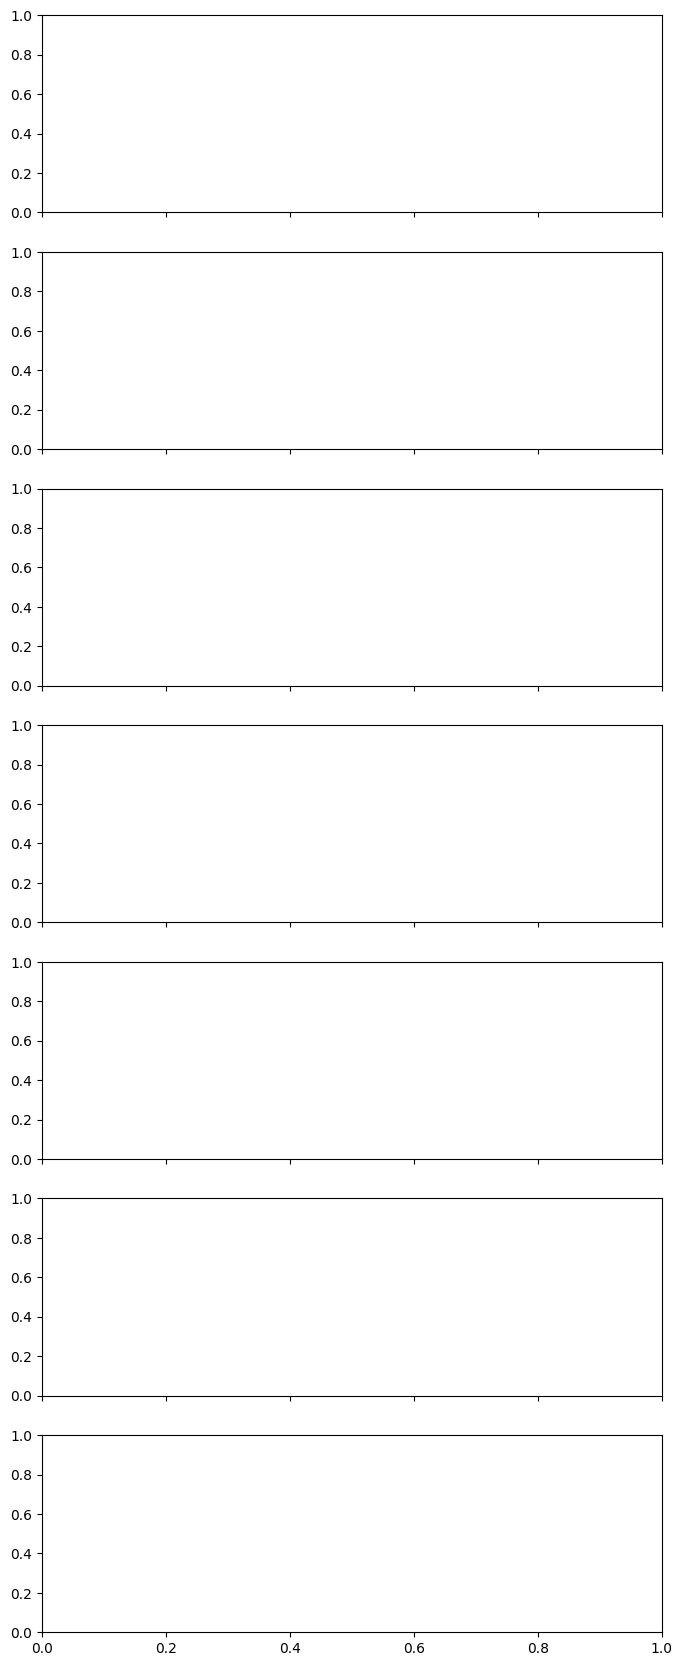

In [ ]:
import matplotlib.pyplot as plt

# 1) Get the unique bins, in your desired order
unique_bins = df_filtered["RUL_binned"].unique()

# 2) Create a figure with one subplot per bin (in a vertical layout)
num_bins = len(unique_bins)
fig, axes = plt.subplots(nrows=num_bins, ncols=1, figsize=(8, 3 * num_bins), sharex=True)

# If there's only 1 bin, `axes` won't be a list, so handle that case
if num_bins == 1:
    axes = [axes]  # make it iterable

# 3) Iterate over each bin and plot all sequences for that bin
for i, bin_label in enumerate(unique_bins):
    # Filter rows that belong to this bin
    df_bin = df_filtered[df_filtered["RUL_binned"] == bin_label]
    
    # Plot each sample's History_120
    for _, row in df_bin.iterrows():
        sequence = row["History_120"]  # Should be length 120
        axes[i].plot(sequence, alpha=0.4)
    
    # (Optional) Add subplot title and label
    axes[i].set_title(f"RUL Bin: {bin_label} ({len(df_bin)} samples)")
    axes[i].set_ylabel("Capacity")
    # We'll set the x-label on the last plot only
    if i == num_bins - 1:
        axes[i].set_xlabel("Index within last 120 capacity points")

plt.tight_layout()
plt.show()


## Model Building and Hyperparameter Tuning

In [ ]:
# Ensure reproducibility (optional)
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # First Conv Layer
    x = Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[5, 7, 9]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Layer
    x = Conv1D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel_size', values=[5, 7, 9]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Third Conv Layer
    x = Conv1D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Dense Layer
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    
    # Dropout
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    
    # Output Layer (Classification for the 3 bins)
    output_layer = Dense(len(label_mapping), activation='softmax')(x)

    # Learning Rate Tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, (1/2)*1e-4])
    
    # Compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_rul_tuning_with_third_layer'
)

tuner.search_space_summary()

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

tuner.results_summary()



Trial 20 Complete [00h 04m 53s]
val_accuracy: 0.7601510882377625

Best val_accuracy So Far: 0.7743154168128967
Total elapsed time: 00h 51m 38s
Results summary
Results in tuner_results/cnn_rul_tuning_with_third_layer
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel_size: 9
l2_reg: 0.001
conv2_filters: 128
conv2_kernel_size: 5
conv3_filters: 128
conv3_kernel_size: 3
dense_units: 64
dropout_rate: 0.3
learning_rate: 0.001
Score: 0.7743154168128967

Trial 07 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel_size: 9
l2_reg: 0.0001
conv2_filters: 64
conv2_kernel_size: 5
conv3_filters: 64
conv3_kernel_size: 5
dense_units: 64
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.7601510882377625

Trial 19 summary
Hyperparameters:
conv1_filters: 48
conv1_kernel_size: 9
l2_reg: 0.001
conv2_filters: 96
conv2_kernel_size: 9
conv3_filters: 96
conv3_kernel_size: 5
dense_units: 192
dropout_rate: 0.4
learning_rate:

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras_tuner import BayesianOptimization

# Ensure reproducibility (optional)
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def build_model_bayes(hp):
    """
    This function defines your CNN model architecture.
    BayesianOptimization will choose hyperparameters from given ranges.
    """
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # First Conv Layer
    x = Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[9, 11, 13]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Layer
    x = Conv1D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel_size', values=[5, 7, 9]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Third Conv Layer
    x = Conv1D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Dense Layer
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    
    # Dropout
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    
    # Output Layer (Classification for your RUL bins)
    output_layer = Dense(len(label_mapping), activation='softmax')(x)

    # Learning Rate Tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-5])
    
    # Compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create a BayesianOptimization tuner
tuner_bayes = BayesianOptimization(
    build_model_bayes,
    objective='val_accuracy',
    max_trials=20,  # how many hyperparameter combinations to try
    num_initial_points=2,  # how many random points to sample before starting to learn
    directory='tuner_results_bayesian',
    project_name='cnn_rul_bayes'
)

# Show the search space summary
tuner_bayes.search_space_summary()

# Conduct the search
tuner_bayes.search(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Summarize the results
tuner_bayes.results_summary()

# Retrieve the best hyperparameters and build a final model
best_hps = tuner_bayes.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner_bayes.hypermodel.build(best_hps)

print("Best Hyperparameters found:")
for param, val in best_hps.values.items():
    print(param, ":", val)



Trial 20 Complete [00h 02m 22s]
val_accuracy: 0.7025495767593384

Best val_accuracy So Far: 0.7431539297103882
Total elapsed time: 00h 59m 50s
Results summary
Results in tuner_results_bayesian/cnn_rul_bayes
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 13
l2_reg: 0.001
conv2_filters: 64
conv2_kernel_size: 7
conv3_filters: 64
conv3_kernel_size: 5
dense_units: 256
dropout_rate: 0.3
learning_rate: 0.0001
Score: 0.7431539297103882

Trial 08 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel_size: 9
l2_reg: 0.0001
conv2_filters: 64
conv2_kernel_size: 9
conv3_filters: 64
conv3_kernel_size: 3
dense_units: 128
dropout_rate: 0.3
learning_rate: 5e-05
Score: 0.7365438938140869

Trial 14 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 9
l2_reg: 0.0005
conv2_filters: 64
conv2_kernel_size: 9
conv3_filters: 128
conv3_kernel_size: 5
dense_units: 256
dropout_rate: 0.6000000000000001
learn

In [33]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras_tuner import BayesianOptimization

# Ensure reproducibility (optional)
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def build_model_bayes(hp):
    """
    This function defines your CNN model architecture.
    BayesianOptimization will choose hyperparameters from given ranges.
    """
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    # First Conv Layer
    x = Conv1D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel_size', values=[9, 11, 13]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Layer
    x = Conv1D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel_size', values=[7, 9]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)


    # Dense Layer
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.0005, 0.0001]))
    )(x)
    
    # Dropout
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    
    # Output Layer (Classification for your RUL bins)
    output_layer = Dense(len(label_mapping), activation='softmax')(x)

    # Learning Rate Tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-5])
    
    # Compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create a BayesianOptimization tuner
tuner_bayes = BayesianOptimization(
    build_model_bayes,
    objective='val_accuracy',
    max_trials=20,  # how many hyperparameter combinations to try
    num_initial_points=2,  # how many random points to sample before starting to learn
    directory='tuner_results_bayesian',
    project_name='cnn_rul_bayes'
)

# Show the search space summary
tuner_bayes.search_space_summary()

# Conduct the search
tuner_bayes.search(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Summarize the results
tuner_bayes.results_summary()

# Retrieve the best hyperparameters and build a final model
best_hps = tuner_bayes.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner_bayes.hypermodel.build(best_hps)

print("Best Hyperparameters found:")
for param, val in best_hps.values.items():
    print(param, ":", val)



Trial 20 Complete [00h 01m 21s]
val_accuracy: 0.756373941898346

Best val_accuracy So Far: 0.763928234577179
Total elapsed time: 00h 57m 47s
Results summary
Results in tuner_results_bayesian/cnn_rul_bayes
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 9
l2_reg: 0.0005
conv2_filters: 96
conv2_kernel_size: 7
dense_units: 192
dropout_rate: 0.6000000000000001
learning_rate: 0.0001
Score: 0.763928234577179

Trial 05 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 11
l2_reg: 0.001
conv2_filters: 32
conv2_kernel_size: 7
dense_units: 64
dropout_rate: 0.4
learning_rate: 5e-05
Score: 0.763928234577179

Trial 09 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 9
l2_reg: 0.0001
conv2_filters: 96
conv2_kernel_size: 7
dense_units: 128
dropout_rate: 0.4
learning_rate: 5e-05
Score: 0.7582625150680542

Trial 12 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 9
l2_reg:

In [34]:
# (Optional) Retrain best model on train+val, then evaluate
best_model.fit(
    np.concatenate([X_train, X_val]),
    np.concatenate([y_train, y_val]),
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val))

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)


Epoch 1/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3476 - loss: 1.8721 - val_accuracy: 0.3692 - val_loss: 1.6376
Epoch 2/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4733 - loss: 1.3876 - val_accuracy: 0.6525 - val_loss: 1.0337
Epoch 3/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5285 - loss: 1.2445 - val_accuracy: 0.5581 - val_loss: 1.1279
Epoch 4/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5712 - loss: 1.1423 - val_accuracy: 0.6176 - val_loss: 0.9870
Epoch 5/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6008 - loss: 1.0902 - val_accuracy: 0.4466 - val_loss: 1.2334
Epoch 6/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6030 - loss: 1.0532 - val_accuracy: 0.6610 - val_loss: 0.9110
Epoch 7/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6310 - loss: 1.0070 - val_accuracy: 0.5269 - val_loss: 1.4114
Epoch 8/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6421 - loss: 0.9749 - val_accu

Top 5 trials:
    trial_id  val_accuracy  conv1_filters  conv1_kernel_size  l2_reg  \
4        04      0.763928             32                  9  0.0005   
5        05      0.763928             32                 11  0.0010   
9        09      0.758263             32                  9  0.0001   
19       19      0.756374             32                  9  0.0010   
12       12      0.756374             32                  9  0.0005   

    conv2_filters  conv2_kernel_size  dense_units  dropout_rate  learning_rate  
4              96                  7          192           0.6        0.00010  
5              32                  7           64           0.4        0.00005  
9              96                  7          128           0.4        0.00005  
19             32                  9          128           0.4        0.00010  
12             96                  7          192           0.6        0.00010  


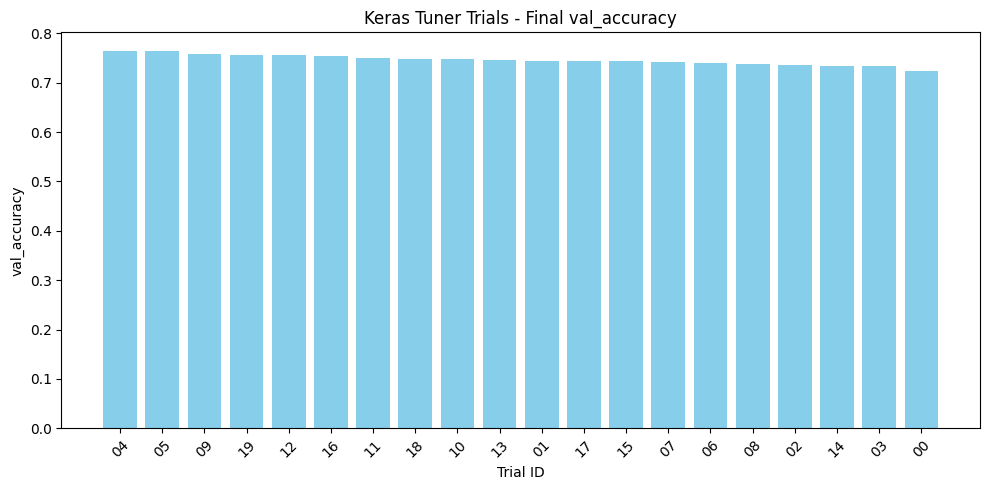

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_tuner_results(tuner):
    """
    Extracts information from the Keras Tuner 'tuner' object
    and returns a Pandas DataFrame with trial results.
    """
    # Each trial (key: trial_id, value: Trial object)
    trials = tuner.oracle.trials
    
    # Build a list of dicts, one per trial
    trial_data = []
    for trial_id, trial in trials.items():
        hp_values = trial.hyperparameters.values
        trial_score = trial.score  # final 'objective' value (val_accuracy) if the trial completed
        
        # Keras Tuner can store 'None' if a trial was stopped early or didn't complete
        if trial_score is None:
            trial_score = float('nan')
        
        # Build a row with the trial ID, final score, and each hyperparameter
        row = {'trial_id': trial_id, 'val_accuracy': trial_score}
        row.update(hp_values)
        trial_data.append(row)
    
    # Convert to Pandas DataFrame
    df_trials = pd.DataFrame(trial_data)
    
    # Sort by best val_accuracy (descending)
    df_trials.sort_values("val_accuracy", ascending=False, inplace=True)
    
    return df_trials

# Example usage:
df_results = analyze_tuner_results(tuner_bayes)

# Print the top 5 trials
print("Top 5 trials:\n", df_results.head(5))

# Plot bar chart of all trial results
plt.figure(figsize=(10, 5))
plt.bar(df_results['trial_id'], df_results['val_accuracy'], color='skyblue')
plt.title("Keras Tuner Trials - Final val_accuracy")
plt.xlabel("Trial ID")
plt.ylabel("val_accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Save df_results to CSV
df_results.to_csv("tuner_random_search_results.csv", index=False)


Validation Accuracy: 0.6091
Test Accuracy: 0.5660
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Tuned Test Accuracy: 0.6105


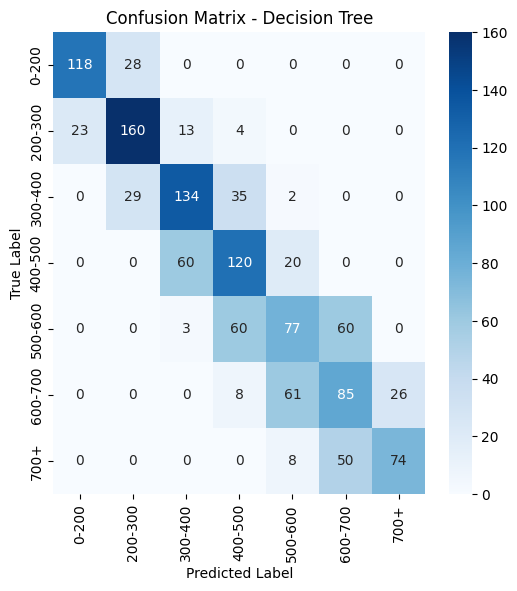

Classification Report (Decision Tree - Tuned Model):
              precision    recall  f1-score   support

       0-200       0.84      0.81      0.82       146
     200-300       0.74      0.80      0.77       200
     300-400       0.64      0.67      0.65       200
     400-500       0.53      0.60      0.56       200
     500-600       0.46      0.39      0.42       200
     600-700       0.44      0.47      0.45       180
        700+       0.74      0.56      0.64       132

    accuracy                           0.61      1258
   macro avg       0.63      0.61      0.62      1258
weighted avg       0.61      0.61      0.61      1258



In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# ---------------------- #
# Data Preprocessing
# ---------------------- #

def preprocess_for_decision_tree(X_train, X_val, X_test, y_train, y_val, y_test):
    """Flattens 3D CNN inputs into 2D for Decision Tree and converts labels from one-hot to integers."""
    X_train_dt = X_train.reshape(X_train.shape[0], -1)
    X_val_dt = X_val.reshape(X_val.shape[0], -1)
    X_test_dt = X_test.reshape(X_test.shape[0], -1)

    y_train_dt = np.argmax(y_train, axis=1)
    y_val_dt = np.argmax(y_val, axis=1)
    y_test_dt = np.argmax(y_test, axis=1)

    return X_train_dt, X_val_dt, X_test_dt, y_train_dt, y_val_dt, y_test_dt

# ---------------------- #
# Decision Tree Training
# ---------------------- #

def train_decision_tree(X_train, y_train):
    """Trains a simple Decision Tree with default parameters."""
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    return dt

# ---------------------- #
# Hyperparameter Tuning
# ---------------------- #

def tune_decision_tree(X_train, y_train):
    """Tunes Decision Tree hyperparameters using GridSearchCV."""
    param_grid = {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5]
    }

    dt_grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1
    )

    dt_grid.fit(X_train, y_train)
    return dt_grid.best_estimator_, dt_grid.best_params_

# ---------------------- #
# Model Evaluation
# ---------------------- #

def evaluate_model(model, X, y, dataset_name="Test"):
    """Evaluates a model on a dataset and prints accuracy."""
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {acc:.4f}")
    return y_pred, acc

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix - Decision Tree"):
    """Plots a confusion matrix."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# ---------------------- #
# Main Execution
# ---------------------- #

# Preprocess data for Decision Tree
X_train_dt, X_val_dt, X_test_dt, y_train_dt, y_val_dt, y_test_dt = preprocess_for_decision_tree(X_train, X_val, X_test, y_train, y_val, y_test)

# Train basic Decision Tree
dt_model = train_decision_tree(X_train_dt, y_train_dt)

# Evaluate basic model
_, val_acc = evaluate_model(dt_model, X_val_dt, y_val_dt, "Validation")
_, test_acc = evaluate_model(dt_model, X_test_dt, y_test_dt, "Test")

# Hyperparameter tuning
best_dt_model, best_params = tune_decision_tree(X_train_dt, y_train_dt)
print(f"Best Parameters: {best_params}")

# Evaluate tuned model
y_test_pred_best, best_test_acc = evaluate_model(best_dt_model, X_test_dt, y_test_dt, "Tuned Test")

# Confusion matrix
plot_confusion_matrix(y_test_dt, y_test_pred_best, label_mapping.keys())

# Classification report
print("Classification Report (Decision Tree - Tuned Model):")
print(classification_report(y_test_dt, y_test_pred_best, target_names=label_mapping.keys()))


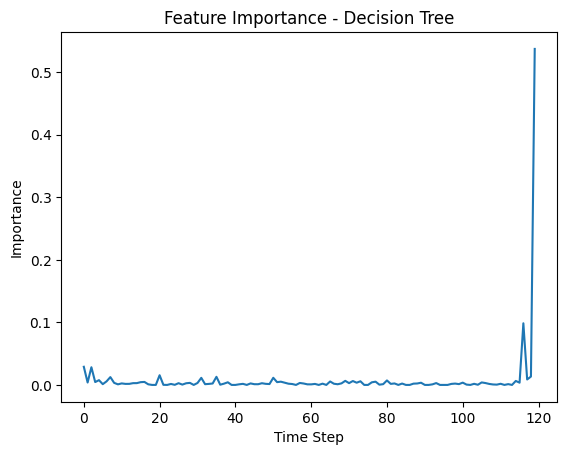

In [43]:
importances = best_dt_model.feature_importances_
plt.plot(importances)
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Time Step")
plt.ylabel("Importance")
plt.show()


In [44]:
from sklearn.tree import export_text

# Export decision tree rules
tree_rules = export_text(best_dt_model, feature_names=[f"Feature_{i}" for i in range(X_train_dt.shape[1])])

print("Decision Tree Rules:")
print(tree_rules)


Decision Tree Rules:
|--- Feature_119 <= 0.45
|   |--- Feature_119 <= 0.36
|   |   |--- Feature_116 <= 0.25
|   |   |   |--- Feature_71 <= 0.51
|   |   |   |   |--- Feature_119 <= 0.19
|   |   |   |   |   |--- Feature_63 <= 0.54
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Feature_63 >  0.54
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Feature_119 >  0.19
|   |   |   |   |   |--- Feature_30 <= 0.60
|   |   |   |   |   |   |--- Feature_69 <= 0.48
|   |   |   |   |   |   |   |--- Feature_55 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Feature_55 >  0.50
|   |   |   |   |   |   |   |   |--- Feature_61 <= 0.49
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Feature_61 >  0.49
|   |   |   |   |   |   |   |   |   |--- Feature_88 <= 0.39
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Feature_88 >  0.39
|   |   |   |   |   |   |   |   

Logistic Regression Test Accuracy: 0.6892


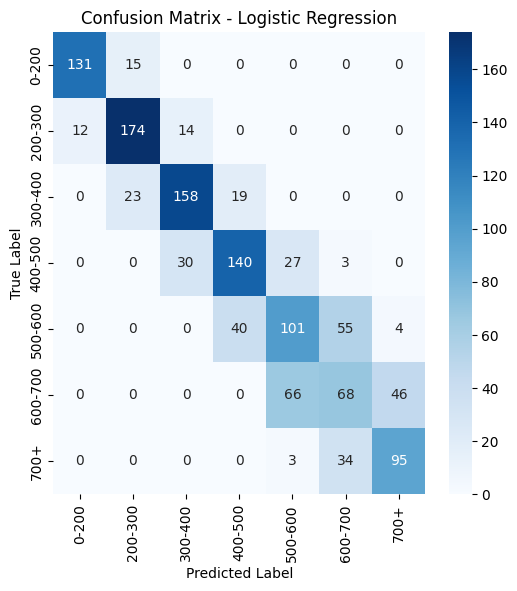

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

       0-200       0.92      0.90      0.91       146
     200-300       0.82      0.87      0.84       200
     300-400       0.78      0.79      0.79       200
     400-500       0.70      0.70      0.70       200
     500-600       0.51      0.51      0.51       200
     600-700       0.42      0.38      0.40       180
        700+       0.66      0.72      0.69       132

    accuracy                           0.69      1258
   macro avg       0.69      0.69      0.69      1258
weighted avg       0.68      0.69      0.69      1258



In [53]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_dt, y_train_dt)

# Evaluate Logistic Regression
y_test_pred_lr, test_acc_lr = evaluate_model(lr_model, X_test_dt, y_test_dt, "Logistic Regression Test")

# Confusion matrix
plot_confusion_matrix(y_test_dt, y_test_pred_lr, label_mapping.keys(), title="Confusion Matrix - Logistic Regression")

# Classification report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test_dt, y_test_pred_lr, target_names=label_mapping.keys()))


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Tuned Logistic Regression Accuracy: 0.7790


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


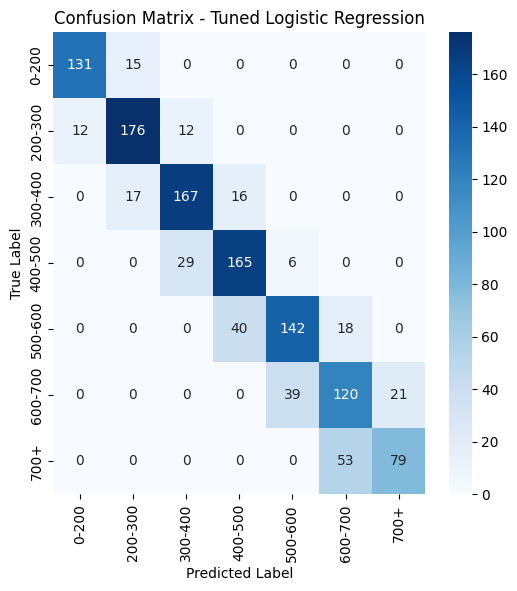

Classification Report (Tuned Logistic Regression):
              precision    recall  f1-score   support

       0-200       0.92      0.90      0.91       146
     200-300       0.85      0.88      0.86       200
     300-400       0.80      0.83      0.82       200
     400-500       0.75      0.82      0.78       200
     500-600       0.76      0.71      0.73       200
     600-700       0.63      0.67      0.65       180
        700+       0.79      0.60      0.68       132

    accuracy                           0.78      1258
   macro avg       0.78      0.77      0.78      1258
weighted avg       0.78      0.78      0.78      1258



In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Compatible solvers
}

# Initialize Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)

# Run GridSearchCV
grid_search_lr = GridSearchCV(
    lr, param_grid, scoring='accuracy', cv=3, n_jobs=-1
)
grid_search_lr.fit(X_train_dt, y_train_dt)

# Get the best model and parameters
best_lr_model = grid_search_lr.best_estimator_
best_lr_params = grid_search_lr.best_params_

print(f"Best Logistic Regression Parameters: {best_lr_params}")

# Evaluate on test set
y_test_pred_lr_tuned, test_acc_lr_tuned = evaluate_model(best_lr_model, X_test_dt, y_test_dt, "Tuned Logistic Regression")

# Confusion Matrix
plot_confusion_matrix(y_test_dt, y_test_pred_lr_tuned, label_mapping.keys(), title="Confusion Matrix - Tuned Logistic Regression")

# Classification Report
print("Classification Report (Tuned Logistic Regression):")
print(classification_report(y_test_dt, y_test_pred_lr_tuned, target_names=label_mapping.keys()))


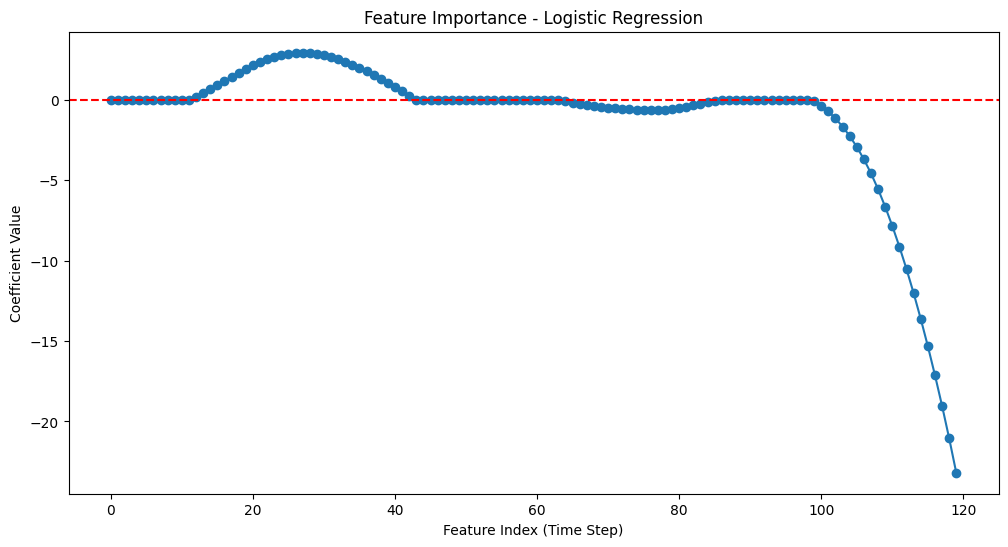

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature coefficients from the trained model
feature_importance = best_lr_model.coef_[0]  # Coefficients for class 0

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.plot(range(len(feature_importance)), feature_importance, marker="o")
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Feature Index (Time Step)")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance - Logistic Regression")
plt.show()


In [73]:
import plotly.express as px
import pandas as pd
import numpy as np

# Get the number of classes and features
num_classes = best_lr_model.coef_.shape[0]
num_features = best_lr_model.coef_.shape[1]

# Create a DataFrame for Plotly
data = []
for class_idx in range(num_classes):
    for feature_idx in range(num_features):
        data.append({
            "Feature Index (Time Step)": feature_idx,
            "Coefficient Value": best_lr_model.coef_[class_idx, feature_idx],
            "Class": list(label_mapping.keys())[class_idx]
        })

df = pd.DataFrame(data)

# Create an interactive Plotly line plot
fig = px.line(
    df, 
    x="Feature Index (Time Step)", 
    y="Coefficient Value", 
    color="Class", 
    markers=True,
    title="Feature Importance - Logistic Regression (All Classes)"
)


# Show the interactive plot
fig.show()


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] E

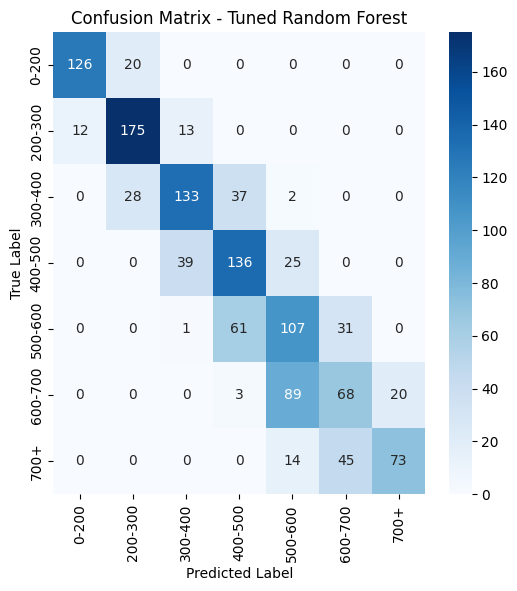

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

       0-200       0.91      0.86      0.89       146
     200-300       0.78      0.88      0.83       200
     300-400       0.72      0.67      0.69       200
     400-500       0.57      0.68      0.62       200
     500-600       0.45      0.54      0.49       200
     600-700       0.47      0.38      0.42       180
        700+       0.78      0.55      0.65       132

    accuracy                           0.65      1258
   macro avg       0.67      0.65      0.65      1258
weighted avg       0.66      0.65      0.65      1258



In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Run GridSearchCV
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, scoring='accuracy', cv=3, n_jobs=-1, verbose=2
)
grid_search_rf.fit(X_train_dt, y_train_dt)

# Get the best model and parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

print(f"Best Random Forest Parameters: {best_rf_params}")

# Evaluate on test set
y_test_pred_rf_tuned, test_acc_rf_tuned = evaluate_model(best_rf_model, X_test_dt, y_test_dt, "Tuned Random Forest")

# Confusion Matrix
plot_confusion_matrix(y_test_dt, y_test_pred_rf_tuned, label_mapping.keys(), title="Confusion Matrix - Tuned Random Forest")

# Classification Report
print("Classification Report (Tuned Random Forest):")
print(classification_report(y_test_dt, y_test_pred_rf_tuned, target_names=label_mapping.keys()))


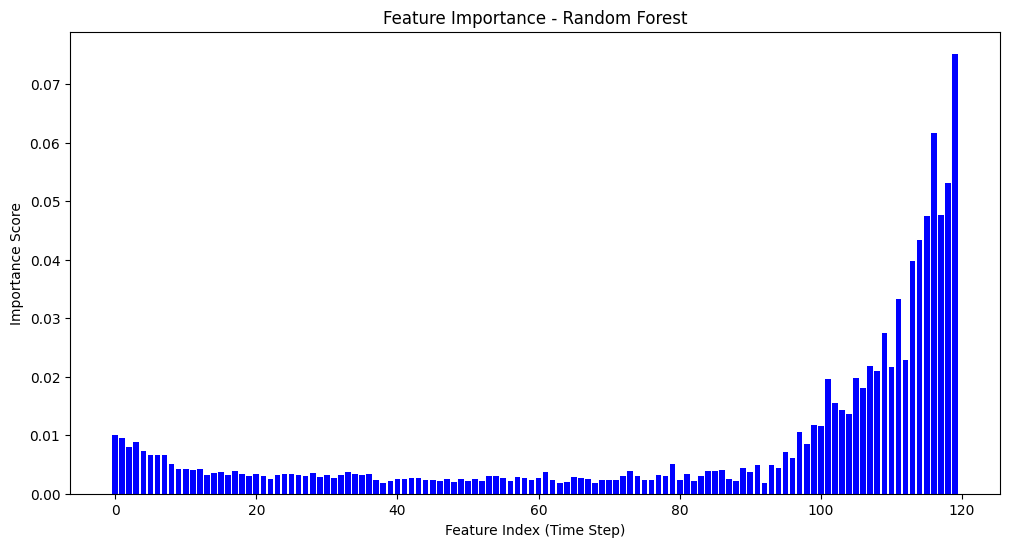

In [75]:
importances = best_rf_model.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances, color="blue")
plt.xlabel("Feature Index (Time Step)")
plt.ylabel("Importance Score")
plt.title("Feature Importance - Random Forest")
plt.show()


# SJEKK OPP OM DET ER SAMMENHENG MELLOM GJENNOMSNITTLIG PLASSERING AV KNEKKPUNKT OG HVOR GRADCAM SER PÅ

In [ ]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print("Best Hyperparameters:")
print(f" - Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f" - Conv1 Kernel Size: {best_hps.get('conv1_kernel_size')}")
print(f" - Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f" - Conv2 Kernel Size: {best_hps.get('conv2_kernel_size')}")
print(f" - Conv3 Filters: {best_hps.get('conv3_filters')}")
print(f" - Conv3 Kernel Size: {best_hps.get('conv3_kernel_size')}")
print(f" - Dense Units: {best_hps.get('dense_units')}")
print(f" - Dropout Rate: {best_hps.get('dropout_rate')}")
print(f" - Learning Rate: {best_hps.get('learning_rate')}")
print()



# Change learning rate to 0.00005
best_model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Combined X shape:", np.concatenate([X_train, X_val]).shape)
print("Combined y shape:", np.concatenate([y_train, y_val]).shape)


# (Optional) Retrain best model on combined training+validation for final test
history = best_model.fit(
    np.concatenate([X_train, X_val]), 
    np.concatenate([y_train, y_val]), 
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val)
    #,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


NameError: name 'history' is not defined

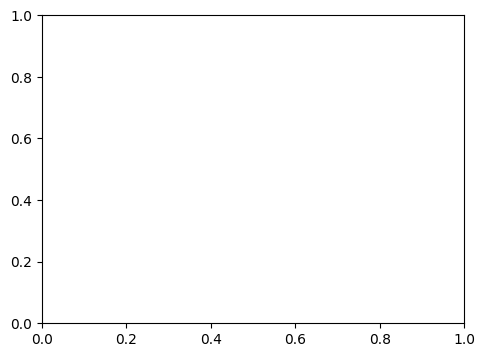

In [22]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Use 'categorical_accuracy' if needed
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       0-200       0.97      0.75      0.84       146
     200-300       0.76      0.81      0.79       200
     300-400       0.76      0.73      0.75       200
     400-500       0.69      0.82      0.75       200
     500-600       0.61      0.77      0.68       200
     600-700       0.50      0.58      0.54       180
        700+       1.00      0.30      0.47       132

    accuracy                           0.70      1258
   macro avg       0.76      0.68      0.69      1258
weighted avg       0.74      0.70      0.70      1258



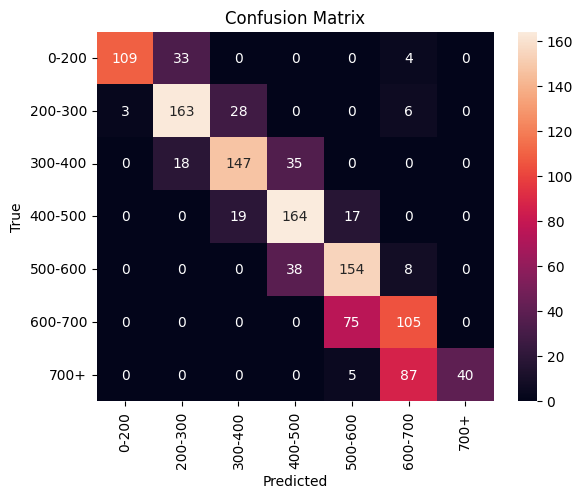

In [36]:
model = best_model

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Ensure consistent labels even if some classes are missing in y_true/y_pred
all_labels = np.arange(len(labels))  # [0, 1, 2, 3, 4]

# Classification report
print(classification_report(y_true, y_pred, labels=all_labels, target_names=labels, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

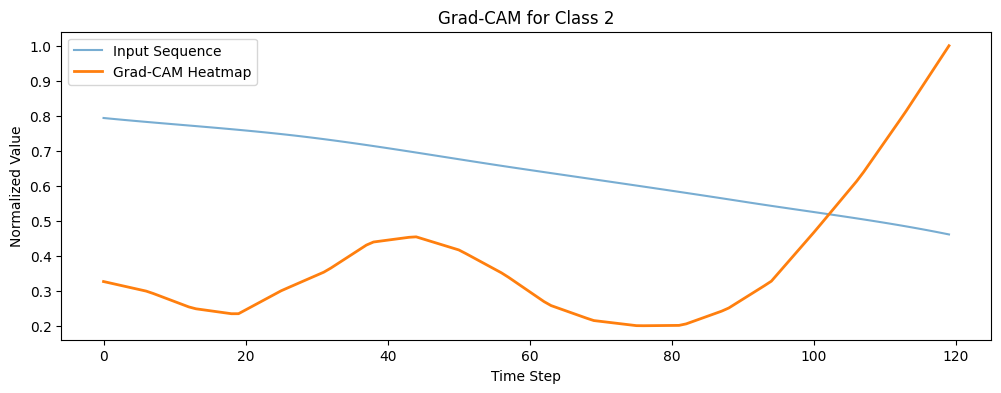

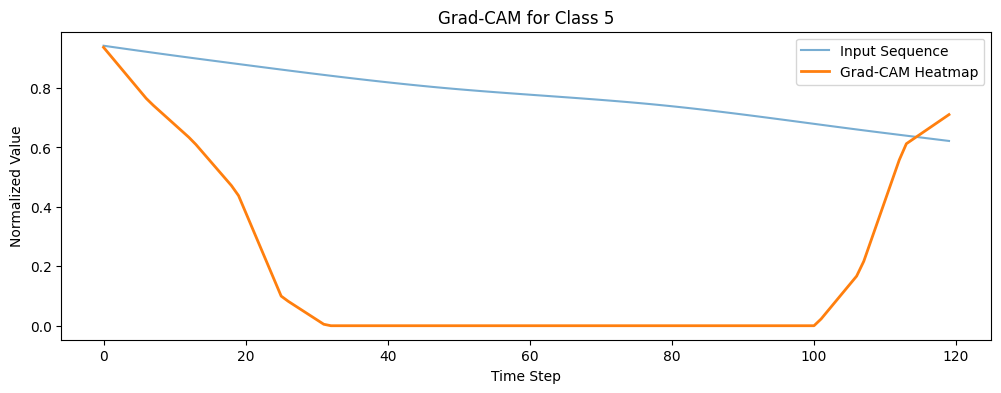

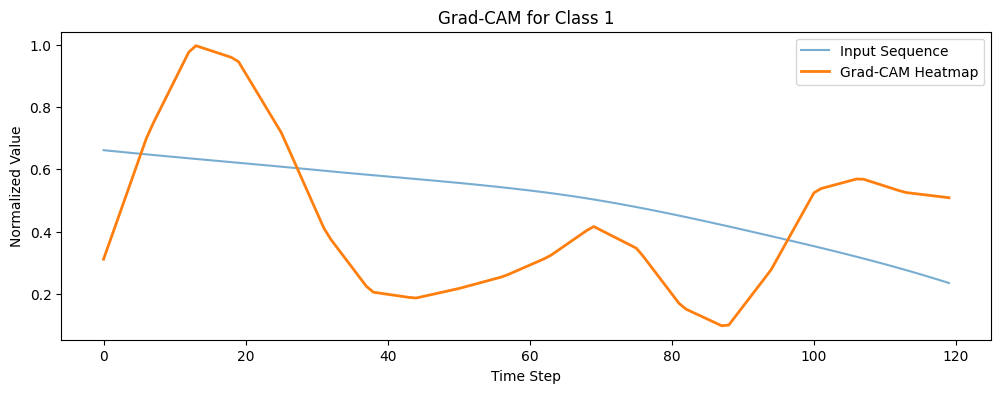

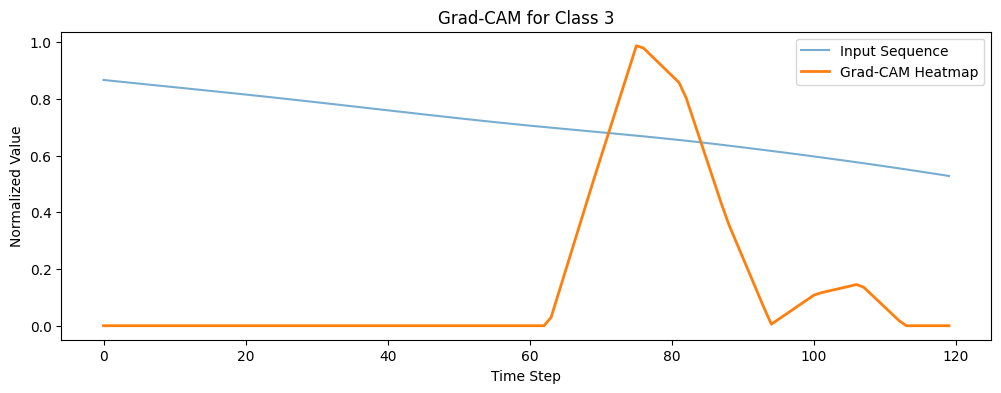

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam_1d(model, input_sequence, class_index, conv_layer_name="conv1d_5"):
    """
    Computes Grad-CAM heatmap for 1D convolutional layers.
    """
    # Ensure input has batch and channel dimensions
    input_sequence = np.expand_dims(input_sequence, axis=(0, -1))  # (1, time_steps, 1)
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)

    # Get target convolutional layer
    conv_layer = model.get_layer(conv_layer_name)

    # Create model to extract feature maps and predictions
    grad_model = Model(inputs=model.input, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        conv_output, predictions = grad_model(input_sequence)
        class_score = predictions[:, class_index]

    # Compute gradients of the class score w.r.t. convolutional output
    grads = tape.gradient(class_score, conv_output)
    if grads is None or np.isnan(grads.numpy()).any():
        print("Warning: Gradients contain NaNs! Replacing with zeros.")
        grads = tf.zeros_like(conv_output)

    # Compute importance weights
    pooled_grads = tf.reduce_mean(grads, axis=1)

    # Apply weights to feature maps
    conv_output = conv_output[0]  # Remove batch dimension
    pooled_grads = pooled_grads[0]  # Remove batch dimension for weights
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-6)

    # Interpolate heatmap to match input sequence length
    input_seq_len = input_sequence.shape[1]
    heatmap_len = len(heatmap)

    if heatmap_len != input_seq_len:
        heatmap_rescaled = np.interp(
            np.arange(input_seq_len),
            np.linspace(0, input_seq_len - 1, heatmap_len),  # Map heatmap length to input length
            heatmap
        )
    else:
        heatmap_rescaled = heatmap  # No interpolation needed if lengths match
    
    return heatmap_rescaled



# Run Grad-CAM on random samples
for i in range(4):
    sample_idx = np.random.randint(len(X_test))
    input_seq = X_test[sample_idx]
    true_label = np.argmax(y_test[sample_idx])

    heatmap = grad_cam_1d(model, input_seq, class_index=true_label)

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.plot(input_seq, label="Input Sequence", alpha=0.6)
    plt.plot(heatmap, label="Grad-CAM Heatmap", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.title(f"Grad-CAM for Class {true_label}")
    plt.legend()
    plt.show()


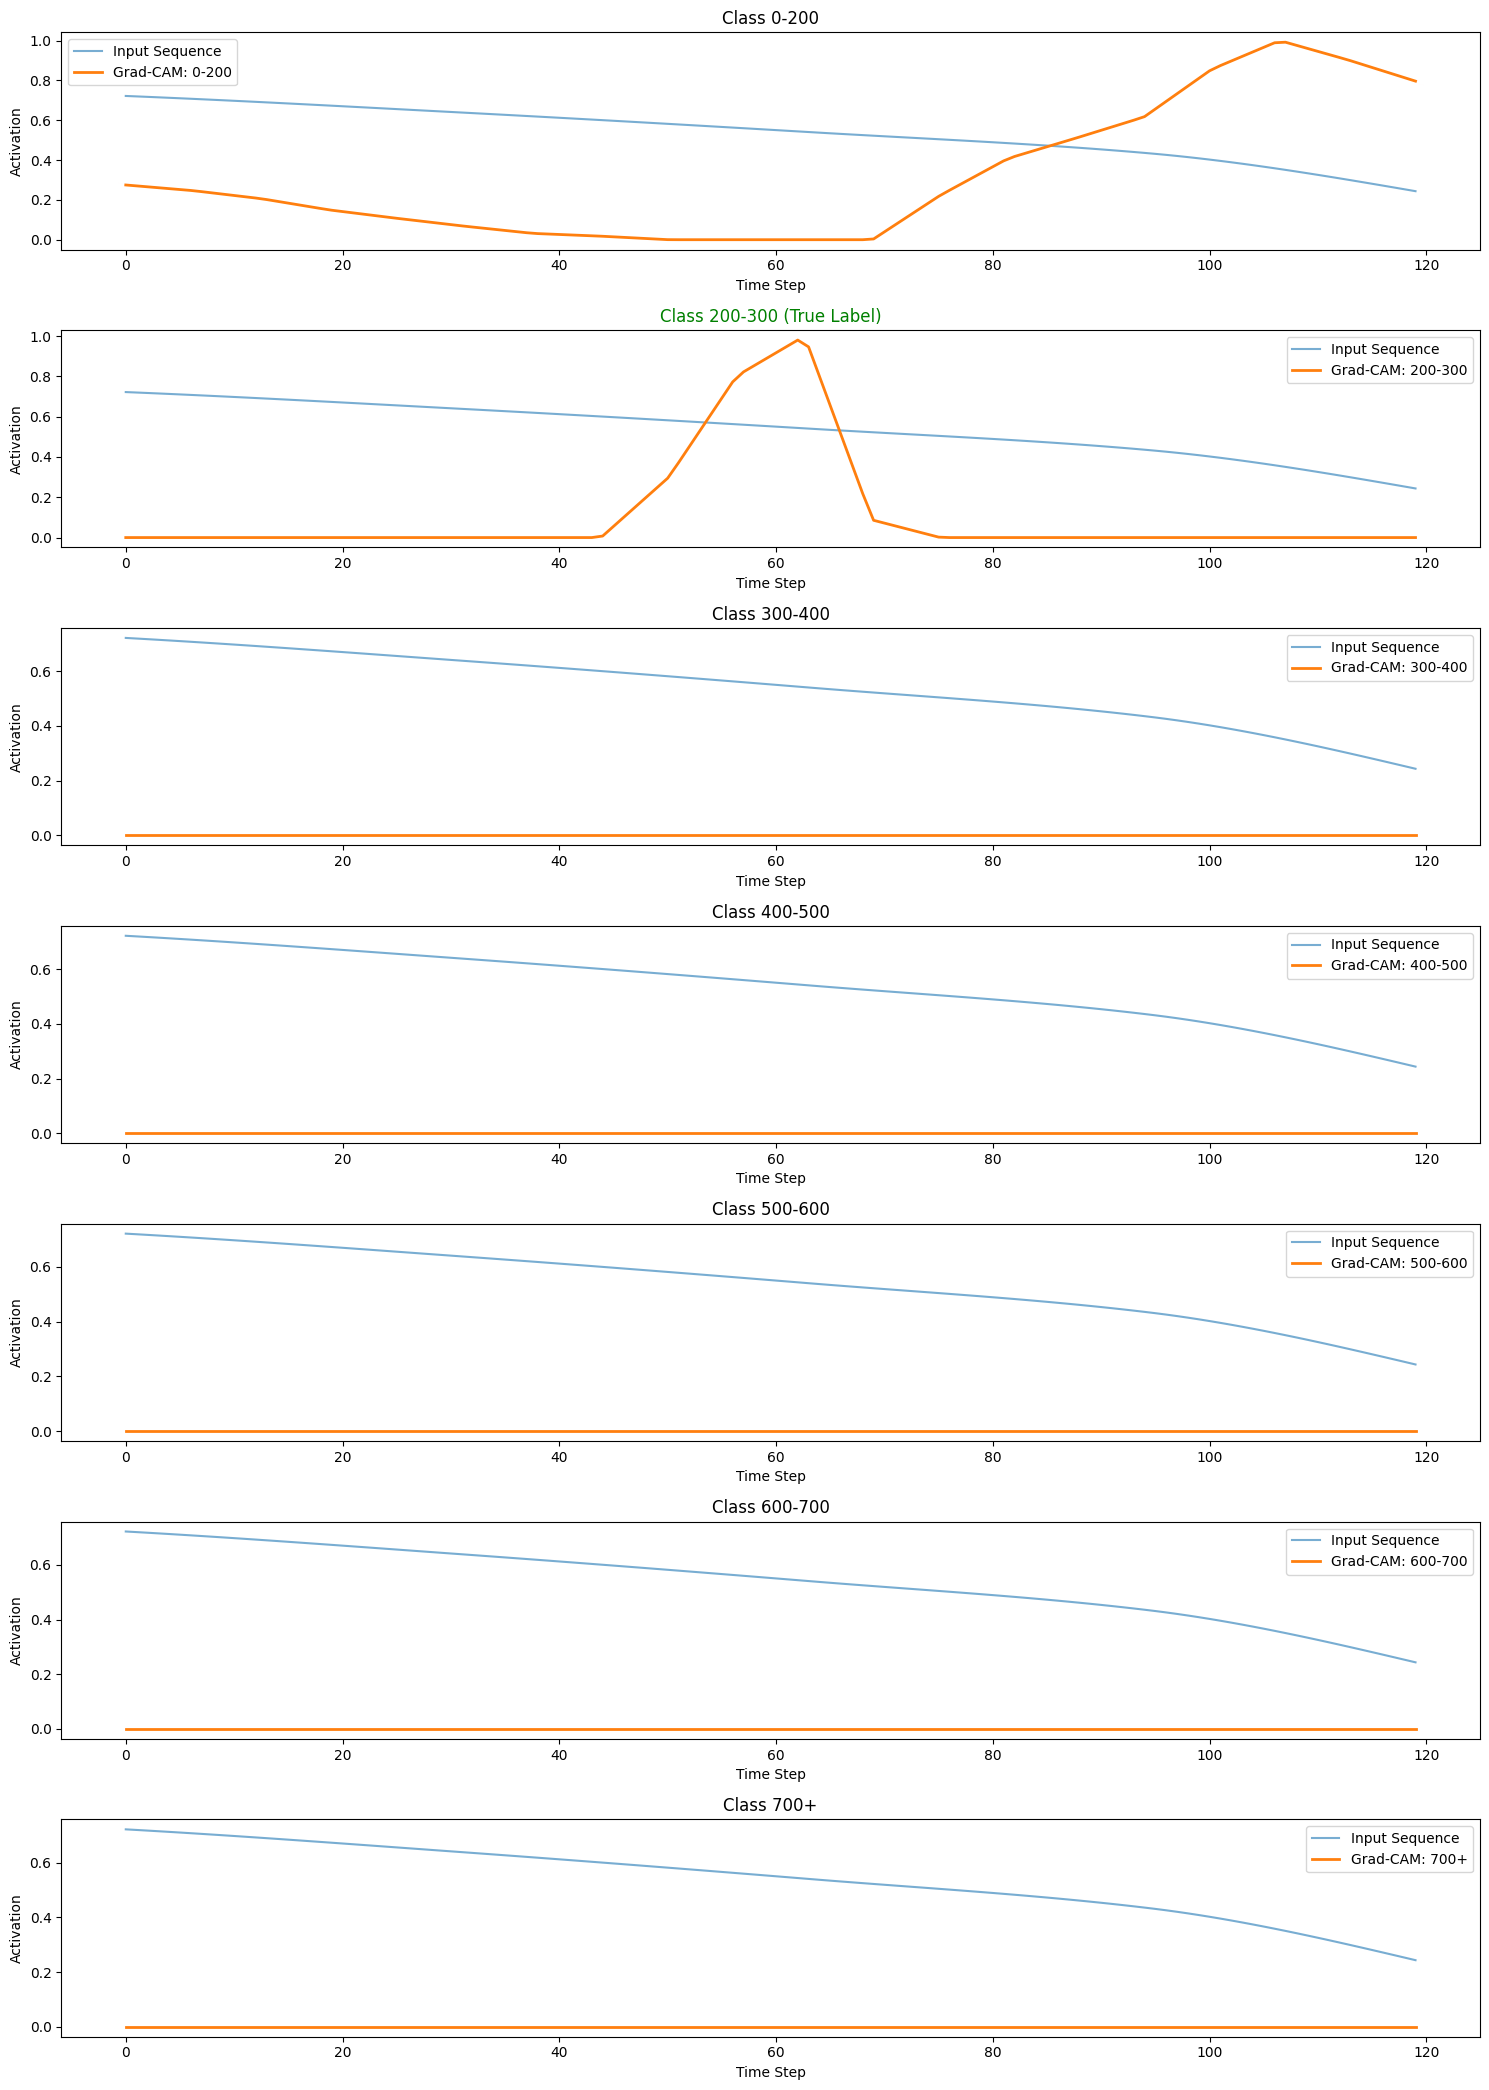

In [30]:
 def plot_grad_cam_for_all_classes(model, input_sequence, true_label, class_labels, conv_layer_name="conv1d_5"):
    """
    Plots Grad-CAM heatmaps for all classes for a given input sequence.

    Args:
        model: Trained Keras model.
        input_sequence: 1D input array.
        true_label: The true class label index.
        class_labels: List of class names.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.
    """
    num_classes = len(class_labels)
    plt.figure(figsize=(15, 3 * num_classes))

    for class_idx in range(num_classes):
        # Compute Grad-CAM heatmap for each class
        heatmap = grad_cam_1d(model, input_sequence, class_index=class_idx, conv_layer_name=conv_layer_name)

        # Plot input sequence and corresponding Grad-CAM heatmap
        plt.subplot(num_classes, 1, class_idx + 1)
        plt.plot(input_sequence.squeeze(), label="Input Sequence", alpha=0.6)
        plt.plot(heatmap, label=f"Grad-CAM: {class_labels[class_idx]}", linewidth=2)
        
        if class_idx == true_label:
            plt.title(f"Class {class_labels[class_idx]} (True Label)", color='green', fontsize=12)
        else:
            plt.title(f"Class {class_labels[class_idx]}", fontsize=12)
            
        plt.xlabel("Time Step")
        plt.ylabel("Activation")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Run Grad-CAM for all classes on a random sample
sample_idx = np.random.randint(len(X_test))
input_seq = X_test[sample_idx]
true_label = np.argmax(y_test[sample_idx])

plot_grad_cam_for_all_classes(model, input_seq, true_label, labels)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Selected Misclassified Sample Index: 825
True Label: 400-500
Predicted Label: 300-400


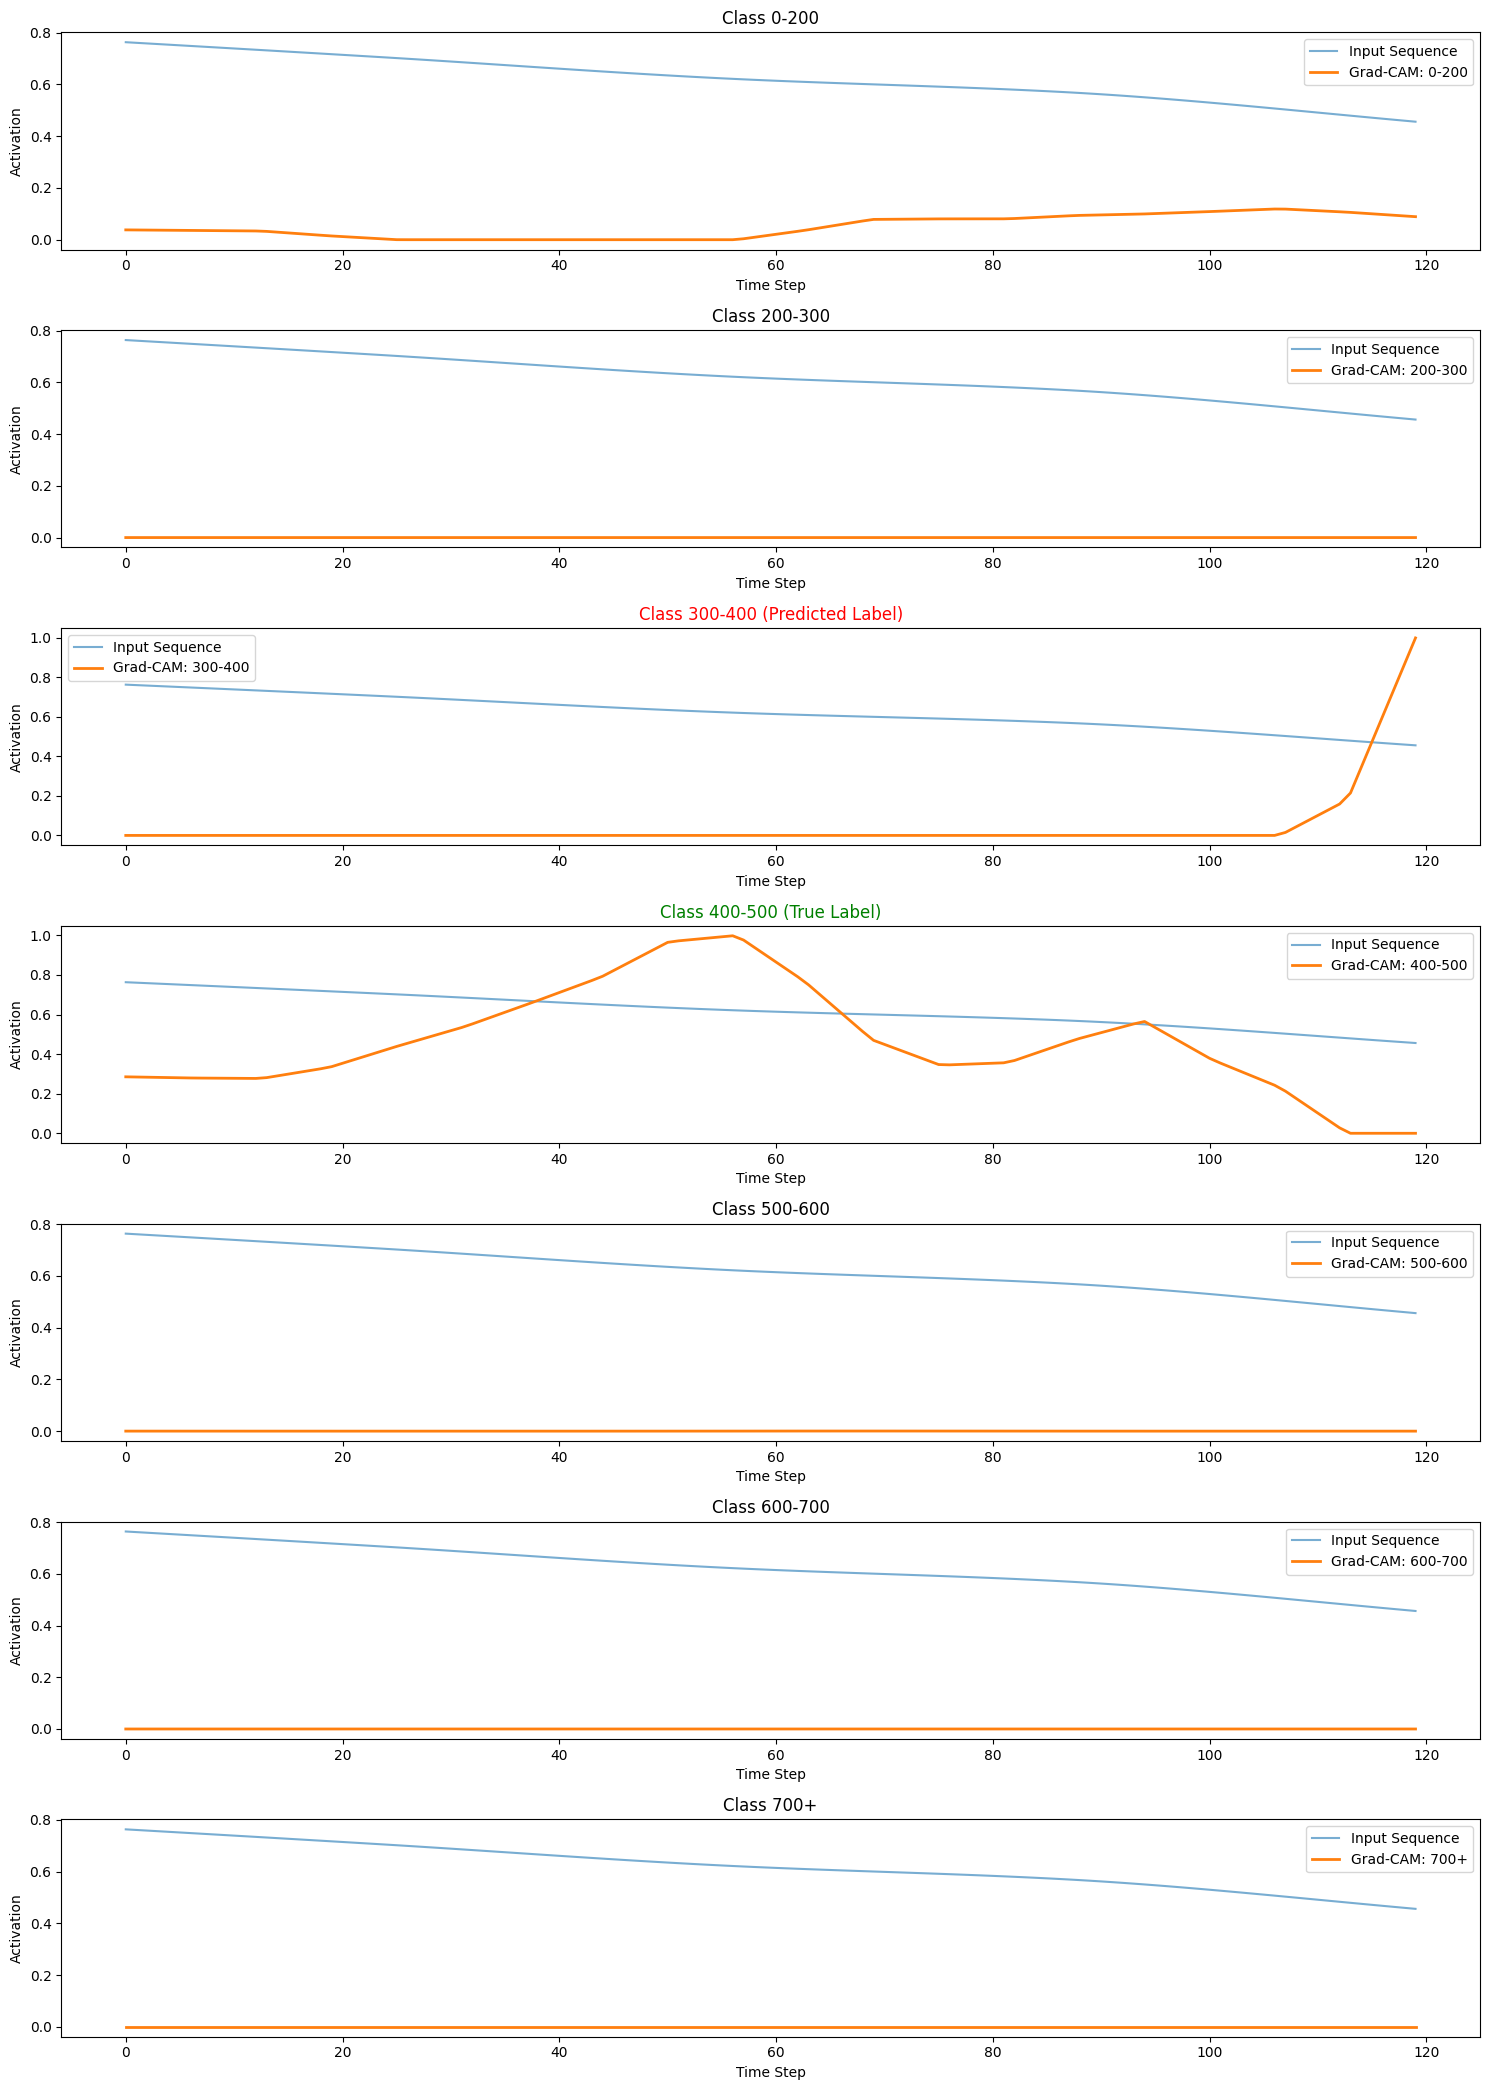

In [31]:
def plot_grad_cam_for_all_classes_misclassified(model, X_test, y_test, class_labels, conv_layer_name="conv1d_5"):
    """
    Finds a misclassified sample and plots Grad-CAM heatmaps for all classes.

    Args:
        model: Trained Keras model.
        X_test: Test data (input sequences).
        y_test: True labels (one-hot encoded).
        class_labels: List of class names.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.
    """
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Find indices of misclassified samples
    misclassified_indices = np.where(y_pred != y_true)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified samples found!")
        return

    # Select a random misclassified sample
    sample_idx = np.random.choice(misclassified_indices)
    input_seq = X_test[sample_idx]
    true_label = y_true[sample_idx]
    predicted_label = y_pred[sample_idx]

    print(f"Selected Misclassified Sample Index: {sample_idx}")
    print(f"True Label: {class_labels[true_label]}")
    print(f"Predicted Label: {class_labels[predicted_label]}")

    # Plot Grad-CAM for all classes
    num_classes = len(class_labels)
    plt.figure(figsize=(15, 3 * num_classes))

    for class_idx in range(num_classes):
        heatmap = grad_cam_1d(model, input_seq, class_index=class_idx, conv_layer_name=conv_layer_name)

        plt.subplot(num_classes, 1, class_idx + 1)
        plt.plot(input_seq.squeeze(), label="Input Sequence", alpha=0.6)
        plt.plot(heatmap, label=f"Grad-CAM: {class_labels[class_idx]}", linewidth=2)

        # Highlight true and predicted labels
        if class_idx == true_label:
            plt.title(f"Class {class_labels[class_idx]} (True Label)", color='green', fontsize=12)
        elif class_idx == predicted_label:
            plt.title(f"Class {class_labels[class_idx]} (Predicted Label)", color='red', fontsize=12)
        else:
            plt.title(f"Class {class_labels[class_idx]}", fontsize=12)

        plt.xlabel("Time Step")
        plt.ylabel("Activation")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Run Grad-CAM visualization for a misclassified sample
plot_grad_cam_for_all_classes_misclassified(model, X_test, y_test, labels)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Selected Sample Index: 1130
True Label: 200-300
Predicted Label: 0-200


ValueError: No such layer: conv1d_23. Existing layers are: ['input_layer_1', 'conv1d_3', 'batch_normalization_3', 'max_pooling1d_3', 'conv1d_4', 'batch_normalization_4', 'max_pooling1d_4', 'conv1d_5', 'batch_normalization_5', 'max_pooling1d_5', 'flatten_1', 'dense_2', 'dropout_1', 'dense_3'].

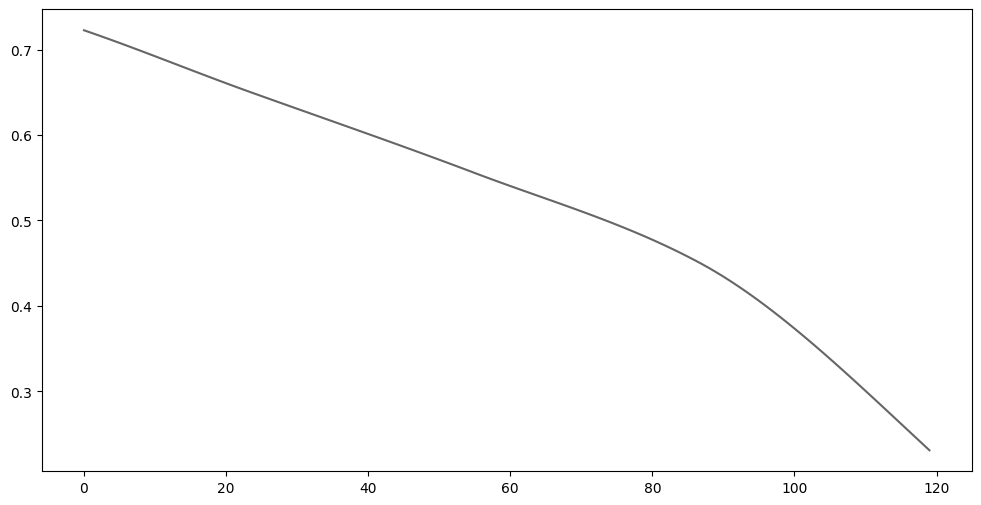

In [27]:
def plot_grad_cam_for_all_classes_single_plot(
    model, 
    X_test, 
    y_test, 
    class_labels, 
    conv_layer_name="conv1d_23", 
    force_misclassified=False
):
    """
    Plots Grad-CAM heatmaps for all classes in a single subplot for one sample.

    Args:
        model: Trained Keras model.
        X_test: Test data (input sequences).
        y_test: True labels (one-hot encoded).
        class_labels: List of class names.
        conv_layer_name: Name of the convolutional layer for Grad-CAM.
        force_misclassified (bool): 
            - If True, try to pick a misclassified sample. 
            - If no misclassified sample exists, fallback to a random sample.
            - If False, pick a random sample (correctly or incorrectly classified).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 2. Find misclassified indices
    misclassified_indices = np.where(y_pred != y_true)[0]

    # 3. Decide whether to pick a misclassified sample or any sample
    if force_misclassified:
        if len(misclassified_indices) > 0:
            sample_idx = np.random.choice(misclassified_indices)
        else:
            print("No misclassified samples found! Picking a random sample instead.")
            sample_idx = np.random.randint(0, len(X_test))
    else:
        sample_idx = np.random.randint(0, len(X_test))

    # 4. Extract data for the chosen sample
    input_seq = X_test[sample_idx]
    true_label = y_true[sample_idx]
    predicted_label = y_pred[sample_idx]

    print(f"Selected Sample Index: {sample_idx}")
    print(f"True Label: {class_labels[true_label]}")
    print(f"Predicted Label: {class_labels[predicted_label]}")

    # 5. Create a single plot for all classes
    plt.figure(figsize=(12, 6))

    # Plot the original sequence
    plt.plot(input_seq.squeeze(), label="Input Sequence", alpha=0.6, color="black")

    # 6. Compute Grad-CAM for each class and overlay
    num_classes = len(class_labels)
    for class_idx in range(num_classes):
        heatmap = grad_cam_1d(model, input_seq, class_index=class_idx, conv_layer_name=conv_layer_name)
        plt.plot(heatmap, label=f"Grad-CAM for {class_labels[class_idx]}")

    # 7. Format the plot
    plt.title(
        "Grad-CAM Overlays — Sample Index: {}\nTrue: {}, Pred: {}".format(
            sample_idx, class_labels[true_label], class_labels[predicted_label]
        ),
        fontsize=14
    )
    plt.xlabel("Time Step")
    plt.ylabel("Grad-CAM Activation")
    plt.legend(loc="upper right")
    plt.show()

plot_grad_cam_for_all_classes_single_plot(model, X_test, y_test, labels, force_misclassified=False)

In [ ]:
def average_grad_cam(model, X_test, y_test, conv_layer_name="conv1d_23"):
    """
    Computes the average Grad-CAM heatmap across the entire test set.

    Args:
        model: Trained Keras model.
        X_test: Test data (input sequences).
        y_test: True labels (one-hot encoded).
        conv_layer_name: Name of the convolutional layer for Grad-CAM.

    Returns:
        avg_heatmaps_per_class: Dictionary with average heatmaps per class.
        global_avg_heatmap: Overall average heatmap across all classes.
    """
    num_classes = y_test.shape[1]
    heatmap_accumulator = {i: [] for i in range(num_classes)}  # Accumulate heatmaps class-wise
    global_heatmap_accumulator = []  # Accumulate all heatmaps for global analysis

    y_pred_probs = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    
    for i in range(len(X_test)):
        input_seq = X_test[i]
        true_class = y_true[i]

        # Generate Grad-CAM for the true class
        heatmap = grad_cam_1d(model, input_seq, class_index=true_class, conv_layer_name=conv_layer_name)

        heatmap_accumulator[true_class].append(heatmap)
        global_heatmap_accumulator.append(heatmap)

    # Compute average heatmaps
    avg_heatmaps_per_class = {cls: np.mean(heatmaps, axis=0) for cls, heatmaps in heatmap_accumulator.items()}
    global_avg_heatmap = np.mean(global_heatmap_accumulator, axis=0)

    return avg_heatmaps_per_class, global_avg_heatmap


def plot_average_grad_cams(avg_heatmaps_per_class, global_avg_heatmap, class_labels):
    """
    Plots the averaged Grad-CAM heatmaps per class and globally.

    Args:
        avg_heatmaps_per_class: Dictionary of average heatmaps per class.
        global_avg_heatmap: Overall average heatmap.
        class_labels: List of class names.
    """
    num_classes = len(class_labels)
    
    plt.figure(figsize=(12, 4 * (num_classes + 1)))

    # Plot per class average Grad-CAMs
    for cls in range(num_classes):
        plt.subplot(num_classes + 1, 1, cls + 1)
        plt.plot(avg_heatmaps_per_class[cls], label=f"Avg Grad-CAM: {class_labels[cls]}")
        plt.title(f"Average Grad-CAM for Class: {class_labels[cls]}")
        plt.xlabel("Time Step")
        plt.ylabel("Activation")
        plt.legend()

    # Plot global average Grad-CAM
    plt.subplot(num_classes + 1, 1, num_classes + 1)
    plt.plot(global_avg_heatmap, label="Global Avg Grad-CAM", color='black', linewidth=2)
    plt.title("Global Average Grad-CAM Across All Classes")
    plt.xlabel("Time Step")
    plt.ylabel("Activation")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [28]:
# Run the average Grad-CAM computation
avg_heatmaps_per_class, global_avg_heatmap = average_grad_cam(model, X_test, y_test, conv_layer_name="conv1d_23")

# Plot the results
plot_average_grad_cams(avg_heatmaps_per_class, global_avg_heatmap, labels)


NameError: name 'average_grad_cam' is not defined

In [ ]:
def separate_correct_and_misclassified(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    correct_indices = np.where(y_pred == y_true)[0]
    misclassified_indices = np.where(y_pred != y_true)[0]

    return X_test[correct_indices], y_test[correct_indices], X_test[misclassified_indices], y_test[misclassified_indices]


# Separate the test set
X_correct, y_correct, X_misclassified, y_misclassified = separate_correct_and_misclassified(model, X_test, y_test)

# Average Grad-CAM for correctly classified samples
avg_heatmaps_correct, _ = average_grad_cam(model, X_correct, y_correct, conv_layer_name="conv1d_23")
# Average Grad-CAM for misclassified samples
avg_heatmaps_misclassified, _ = average_grad_cam(model, X_misclassified, y_misclassified, conv_layer_name="conv1d_23")

# Plot comparison
plot_average_grad_cams(avg_heatmaps_correct, global_avg_heatmap, labels)
plot_average_grad_cams(avg_heatmaps_misclassified, global_avg_heatmap, labels)
